## Determining an Unknown Players Basketball Position Using K-Nearest Neighbor Classification 

### Marcus Lam (20704185),  Elaina Qiu(94709888), Tegvir Multani (49064660), Joel Jacob (48284525)

### Introduction
In the game of basketball, there are five positions or roles that players play: Point Guard (PG), Shooting Guard (SG), Small Forward (SF), Power Forward (PF), and Center (C). With our project, we aim to classify a given unknown player into one of these five positions using the K-Nearest Neighbor classification algorithm. We are using the official player statistics from the 2022-2023 NBA season as our dataset as it’s the most popular league and updated player stats. The dataset contains the names of all the players that played in the 2022-2023 NBA season along with their identifying information (team, age, position), and player statistics (points, rebounds, assists, blocks, steals, turnovers and shooting percentage). We will be using the information in this dataset to create our K-Nearest neighbor classification models in order to run the algorithm.


### Loading Libraries:
- Loading the corresponding R-packages required to run our analysis

In [1]:
suppressPackageStartupMessages({
    suppressWarnings ({
    library(tidyverse)
    library(repr)
    library(tidymodels)
    library(GGally)
    options(repr.matrix.max.rows = 6)})})

### Downloading and Reading File:

In [2]:
options(readr.show_col_types = FALSE) 
download.file("https://raw.githubusercontent.com/Elalalaqqq/DSCI-100-2023W2-GROUP-28/main/data/2022-2023%20NBA%20Player%20Stats%20-%20Regular.csv", "data/nbadata.csv")
nbaStats <- read_csv2("data/nbadata.csv")
nbaStats

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.



Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,⋯,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Precious Achiuwa,C,23,TOR,55,12,207,3.6,7.3,⋯,0.702,1.8,4.1,6,0.9,0.6,0.5,1.1,1.9,9.2
2,Steven Adams,C,29,MEM,42,42,27,3.7,6.3,⋯,0.364,5.1,6.5,11.5,2.3,0.9,1.1,1.9,2.3,8.6
3,Bam Adebayo,C,25,MIA,75,75,346,8,14.9,⋯,0.806,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
537,Omer Yurtseven,C,24,MIA,9,0,92,1.8,3,⋯,0.833,0.9,1.7,2.6,0.2,0.2,0.2,0.4,1.8,4.4
538,Cody Zeller,C,30,MIA,15,2,145,2.5,3.9,⋯,0.686,1.7,2.6,4.3,0.7,0.2,0.3,0.9,2.2,6.5
539,Ivica Zubac,C,25,LAC,76,76,286,4.3,6.8,⋯,0.697,3.1,6.8,9.9,1,0.4,1.3,1.5,2.9,10.8


### Filter Stats For Minimum 50 Games Played
- Wrangled and cleaned the data from its original downloaded format so that the data set is tidy and necessary for the planned analysis. Filtered data to include the position (dependent variable) and all the predictor variables (rebounds, assists, steals, blocks, turnovers, fouls, and three pointers attempted, free throws attempted) that we will use to predict the player position. We chose these specific dependent variables out of the larger list provided in the original data set as previous studies have built similar models based on these variables; therefore, these dependent variables may be the most important basketball statistpointics relating to each position.  
- 

In [3]:
set.seed(2024)
filteredStats <- nbaStats |>
    group_by(Player) |>
    filter(n() == 1 | Tm == "TOT", G >= 50, !(Pos %in% c("PF-SF", "SF-SG", "SG-PG"))) |>
    ungroup() |>
    select("Pos", "FTA", "3PA", "TRB":"PTS") |>
    mutate(Pos = as.factor(Pos),
          across(where(is.character), as.numeric))
filteredStats

Pos,FTA,3PA,TRB,AST,STL,BLK,TOV,PF,PTS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C,2.3,2.0,6.0,0.9,0.6,0.5,1.1,1.9,9.2
C,5.4,0.2,9.2,3.2,1.2,0.8,2.5,2.8,20.4
SG,1.2,3.9,2.1,1.1,0.3,0.3,0.7,1.7,7.9
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
PF,0.5,0.6,3.1,1.4,1.0,0.1,0.8,1.6,4.4
PG,8.8,6.3,3.0,10.2,1.1,0.1,4.1,1.4,26.2
C,3.1,0.0,9.9,1.0,0.4,1.3,1.5,2.9,10.8


### Get Mean For Each Position:
- We obtain the mean of the predictor variables across all of the positions and compared them with bar plots. This also suggests what predictor variables are similar or different across the different positions. 

In [4]:
positionMean <- filteredStats |>
                group_by(Pos) |>
                summarize(count = n(), across(everything(), \(x) mean(x, na.rm = TRUE)))
positionMean

Pos,count,FTA,3PA,TRB,AST,STL,BLK,TOV,PF,PTS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C,53,3.016981,1.488679,7.358491,1.949057,0.6188679,1.0358491,1.409434,2.526415,12.04528
PF,59,2.325424,3.101695,5.040678,1.959322,0.6322034,0.5050847,1.240678,1.972881,10.92373
PG,56,3.041071,4.641071,3.446429,4.973214,1.0214286,0.3196429,1.864286,1.921429,14.16964
SF,53,2.181132,3.901887,3.849057,1.843396,0.7226415,0.3452830,1.120755,1.933962,11.41887
SG,74,2.274324,4.587838,3.245946,2.658108,0.7770270,0.2783784,1.390541,1.831081,12.70405


### Create Mean Statistics Plot For Each Position Using pivot_longer() and facet_wrap()

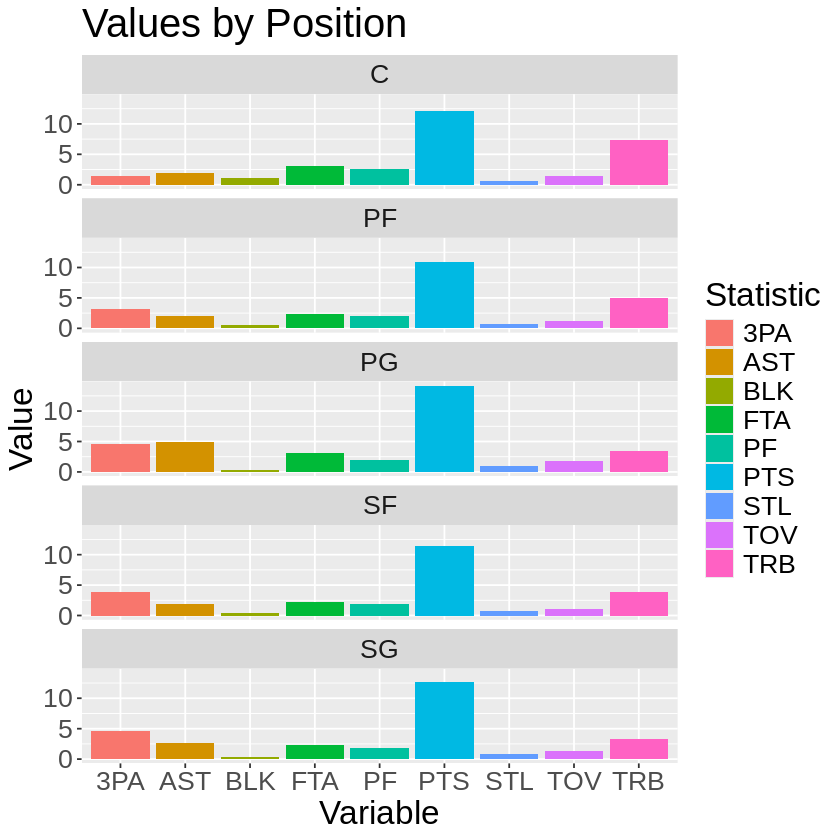

In [5]:
positionMeanLong <- positionMean |>
                    select(-count) |>
                    pivot_longer(cols = -Pos, names_to = "Variable", values_to = "Value")

positionMeanPlot <- positionMeanLong |>
                    ggplot(aes(x = Variable, y = Value, fill = Variable)) +
                    geom_bar(stat = "identity", position = "dodge") +
                    facet_wrap(~Pos, scales = "fixed", ncol = 1) +
                    labs(title = "Values by Position",
                       x = "Variable",
                       y = "Value",
                       fill = "Statistic") +
                    theme(text = element_text(size = 20))

positionMeanPlot

## Performing Data Analysis
- We will be using the k-nn algorithm to predict the position of a player based on stats.
- First, we need to select the $k$ value that has the highest accuracy in predictions. To do this we will split the data into a training set and a testing set and perform a 10-fold cross-validation on the training set.

In [6]:
set.seed(2024)

nba_split <- initial_split(filteredStats, prop = .9, strata = Pos)
nba_training <- training(nba_split)
nba_testing <- testing(nba_split)

nba_training_recipe <- recipe(Pos ~ ., data = nba_training) |> 
    step_scale(all_predictors()) |>
    step_center(all_predictors())

nba_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
	set_engine("kknn") |> 
	set_mode("classification") 

nba_vfold <- vfold_cv(nba_training, v = 10, strata = Pos)

nba_cv_results <- workflow() |>
    add_recipe(nba_training_recipe) |>
    add_model(nba_tune) |>
    tune_grid(resamples = nba_vfold, grid = tibble(neighbors = seq(2, 18, by = 1))) |>
    collect_metrics()

- Plot the accuracy vs K value to determine the best K value to use

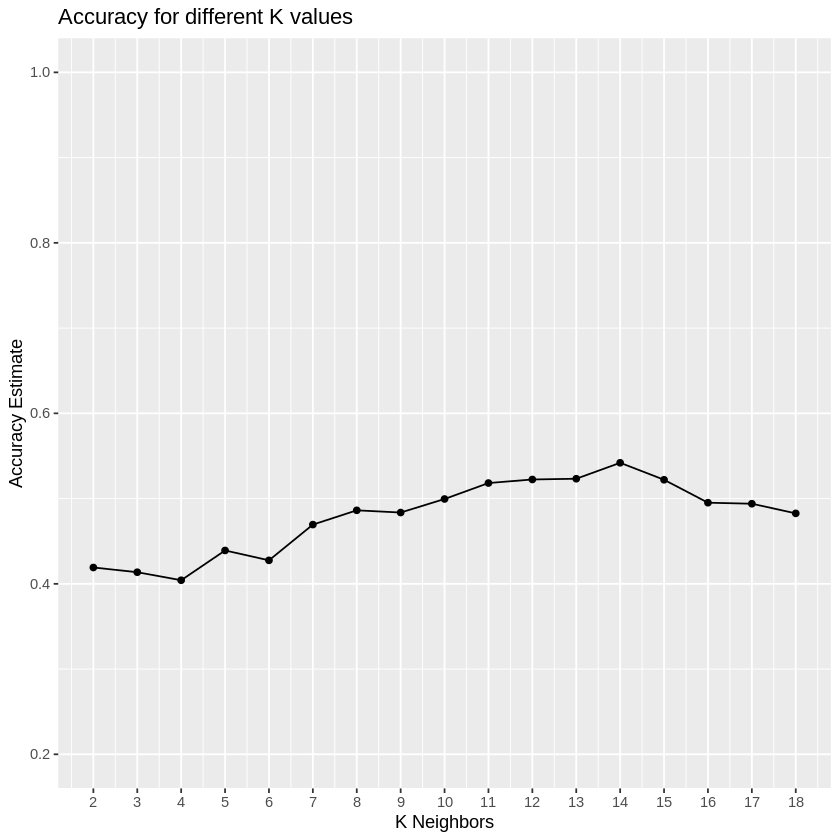

In [7]:
k_accuracy_plot <- nba_cv_results |>
    filter(.metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K Neighbors", y = "Accuracy Estimate") +
    ggtitle("Accuracy for different K values") +
    scale_x_continuous(breaks = seq(0, 20, by = 1)) +
    scale_y_continuous(limits = c(0.2, 1.0))

k_accuracy_plot

### Building our model with K = 14

- Our analysis determined that a K value of 14 is optimal for our model as it has the highest accuracy.
- We will test our model by computing performance metrics on the testing set.

In [8]:
set.seed(2024)

nba_spec <- nearest_neighbor(weight = "rectangular", neighbors = 14) |>
    set_engine("kknn") |>
    set_mode("classification")

nba_fit <- workflow() |>
    add_recipe(nba_training_recipe) |>
    add_model(nba_spec) |>
    fit(data = nba_training)

nba_test_predictions <- predict(nba_fit, nba_testing) |>
    bind_cols(nba_testing) |>
    metrics(truth = Pos, estimate = .pred_class)

nba_test_predictions 

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5937500
kap,multiclass,0.4901961


### Creating a more accuracte classifier by combining similar positions into more general positions
**Before we created:**
- 1 model classifying into 5 unique basketball positions (Point Guard, Shooting Guard, Small Forward, Power Forward, Center)
  
**Now we will make:**
- Another model classifying into 3 unique (more general) basketball positions (Guard, Forward, Center) 
- Each model has the same steps, except for the data wrangling portion where PG/SG will be combined into “Guard” (G) and SF/PF will be combined into “Forwards” (F).

In [9]:
set.seed(2024)

three_pos_stats <- filteredStats |>
    mutate(Pos = as.factor(as.character(case_when(Pos == "PG" | Pos == "SG" ~ "G",
                         Pos == "PF" | Pos == "SF" ~ "F",
                         Pos == "C" ~ "C"))))

nba_3_split <- initial_split(three_pos_stats, prop = .9, strata = Pos)
nba_3_training <- training(nba_3_split)
nba_3_testing <- testing(nba_3_split)

nba_3_training_recipe <- recipe(Pos ~ ., data = nba_3_training) |> 
    step_scale(all_predictors()) |>
    step_center(all_predictors())

nba_3_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
	set_engine("kknn") |> 
	set_mode("classification") 

nba_3_vfold <- vfold_cv(nba_3_training, v = 10, strata = Pos)

nba_3_cv_results <- workflow() |>
    add_recipe(nba_3_training_recipe) |>
    add_model(nba_3_tune) |>
    tune_grid(resamples = nba_3_vfold, grid = tibble(neighbors = seq(2, 18, by = 1))) |>
    collect_metrics()

- Plot the accuracy vs K value to determine the best K value to use

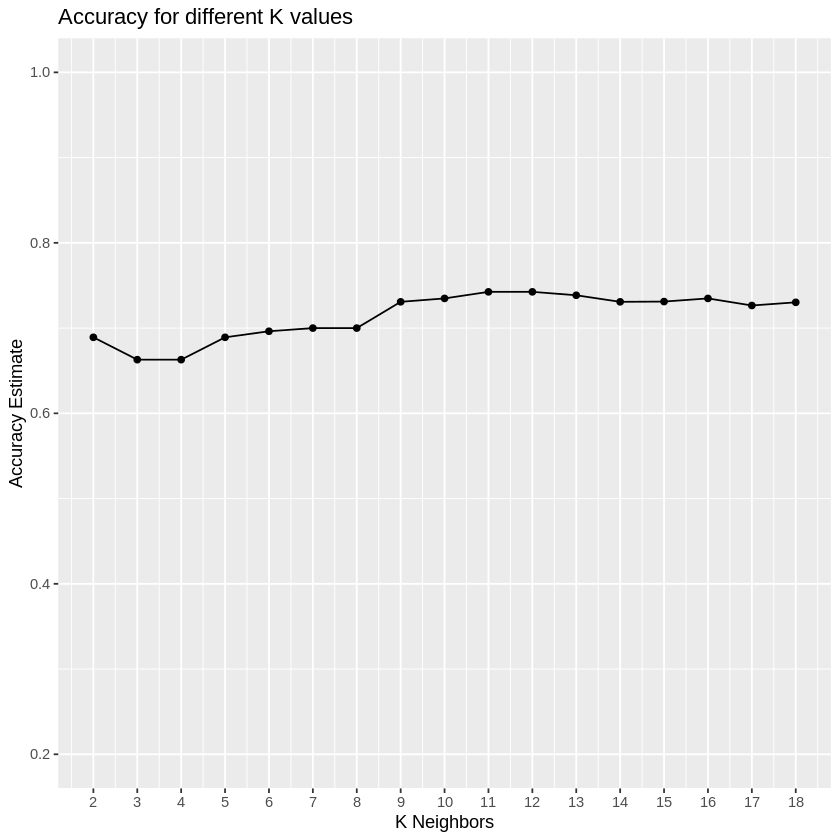

In [10]:
k_accuracy_plot <- nba_3_cv_results |>
    filter(.metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K Neighbors", y = "Accuracy Estimate") +
    ggtitle("Accuracy for different K values") +
    scale_x_continuous(breaks = seq(0, 20, by = 1)) +
    scale_y_continuous(limits = c(0.2, 1.0))

k_accuracy_plot

### Building our model with K = 12

- Our analysis determined that a K value of 12 is optimal for our model as it has the highest accuracy.
- We will test our model by computing performance metrics on the testing set.

In [11]:
set.seed(2024)

nba_3_spec <- nearest_neighbor(weight = "rectangular", neighbors = 12) |>
    set_engine("kknn") |>
    set_mode("classification")

nba_3_fit <- workflow() |>
    add_recipe(nba_3_training_recipe) |>
    add_model(nba_3_spec) |>
    fit(data = nba_3_training)

nba_3_test_predictions <- predict(nba_3_fit, nba_3_testing) |>
    bind_cols(nba_3_testing) |>
    metrics(truth = Pos, estimate = .pred_class)

nba_3_test_predictions 

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8064516
kap,multiclass,0.6900000


## Discussion:

As seen from the results, when using the predictors rebounds, assists, steals, blocks, faults, fouls, and scores, we found the optimal K neighbors value to be 14, which produces a final classification model with an average accuracy of 55%. Considering the relatively low accuracy, we merged the roles with similar responsibilities, namely the point guards/shooting guards (PG/SG) and small forwards/power forwards (SF/PF), to redefine the classification into three positions(Guard, Forward, Center). We then reapplied the K-Nearest Neighbor algorithm to make predictions under this new three-position framework and produce a final classification model with an average accuracy of 74.2%. 
The accuracy of 55% with the initial model categorizing into the 5 unique positions (Point Guard, Shooting Guard, Small Forward, Power Forward, Center) was not what we expected as we thought our accuracy would be much higher. Therefore, to make our model more usable, we decided to categorize into 3 unique positions (Guard, Forward, Center) instead by making the positions more broad/generic. 
The diminished accuracy observed in the analysis may be attributed to the inherent similarities between the roles of point guards/shooting guards (PG/SG) and small forwards/power forwards (SF/PF). These positional overlaps likely confounded the k-nearest neighbors (KNN) algorithm, leading to misclassifications during the evaluation process. By merging similar positions such as point guards/shooting guards (PG/SG) into 'Guard' and small forwards/power forwards (SF/PF) into 'Forward', the ambiguity in the classification process is significantly reduced. The roles within these merged categories share more homogeneous playing styles and statistical profiles, leading to clearer distinctions for the KNN algorithm to identify.
These findings carry considerable implications. Specifically, the ability to classify positions accurately can inform strategic decisions regarding the optimal court placement of players. Such insights may reveal whether a player could achieve greater efficacy by assuming a different position on the court.
Our model could lead to future questions, such as “what happens to our accuracy if we included more predictor variables?” or “would our model be more accurate if we had the height of each player and included it in our predictor variables?” We wonder if there are any other significant predictor variables that could help our model, or if any of the ones we’re using is deterring our model from being most accurate. 


## References

Baumann, A. (2022). A Multi-Stage Clustering Algorithm to Re-Evaluate Basketball Positions and Performance Analysis. National College of Ireland. 

Diegobormor. (2023). NBA 2022-2023 Data overview. Kaggle. 

Guo, P., Lu, F., Zhang, L., et al. (2016). Application of K-means clustering algorithm for classification of NBA guards. International Journal of Science and Engineering Applications. 5: 2319-7560. 
